In [1]:
import os
import numpy as np
import pandas as pd
from   astropy.table import Table
from   astropy.io import fits
import pylab as pl
from   glob import glob
from   desitarget.targetmask import desi_mask, bgs_mask
from   desitarget.sv3 import sv3_targetmask

In [2]:
from   io import BytesIO 
from   io import StringIO
import requests
import numpy as np 
from   PIL import Image

def load_image(url): 
    res = requests.get(url)
    img_arr = np.array(Image.open(BytesIO(res.content)))
    return img_arr

/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv3-bright-pernight.fits
bright fuji sv3 188925


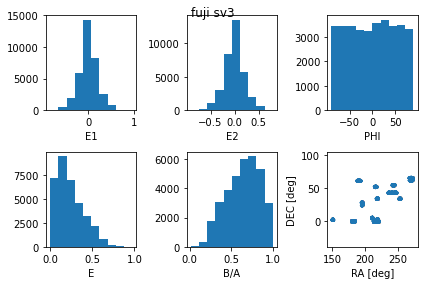

/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv3-dark-pernight.fits
dark fuji sv3 155051


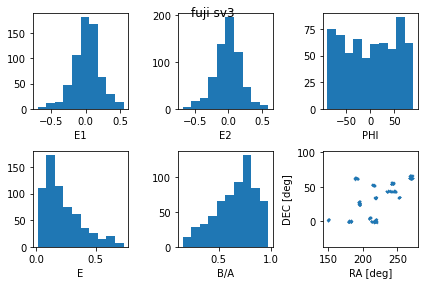

In [3]:
flavours = ['bright','dark']

releases = ['everest','everest','fuji','fuji','guadalupe']
svs      = ['sv1',      'sv3',    'sv1','sv3',   'main']

# releases = ['fuji','fuji','fuji']
# svs      = ['sv1','sv2','sv3']

releases = ['fuji']
svs      = ['sv3']

for flavour in flavours:
    for release, sv in zip(releases,svs):
        # path = f'/global/cfs/cdirs/desi/target/catalogs/dr9/1.0.0/targets/main/resolve/{flavour}'
        file = f'/global/cfs/cdirs/desi/spectro/redux/{release}/zcatalog/ztile-{sv}-{flavour}-pernight.fits'
        print(file)
        data = Table.read(file)
        data = data[[name for name in data.colnames if len(data[name].shape) <= 1]]
        data = data.to_pandas()        
        
        lss_data = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/EDAbeta/BGS_BRIGHT_full.dat.fits')
        lss_data = lss_data[[name for name in lss_data.colnames if len(lss_data[name].shape) <= 1]]
        lss_data = lss_data.to_pandas()
        
        # df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_everest_sv1_data.csv'))
        # df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_everest_sv3_data.csv'))
        # df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_fuji_sv1_data.csv'))
        data = data.append(lss_data)
        # df_des = df_des.append(pd.read_csv(f'./data/DR9_BGS{flavour.upper()}_guadalupe_main_data.csv'))
        data = data.drop_duplicates()        
        
        # Reading the R value: Half-light radius of galaxy model
        # Reading the E1 value: Ellipticity component 1 of galaxy model
        # Reading the E2 value: Ellipticity component 2 of galaxy model
        # https://www.legacysurvey.org/dr9/catalogs/#ellipticities
        ii_notnull = (np.ones(len(data), dtype=bool))  & (data['SHAPE_E1'] != 0) & (data['SHAPE_E2'] != 0) & (data['GAIA_PHOT_G_MEAN_MAG'] != 0)
        
        is_target = (np.ones(len(data), dtype=bool)) #& (data['BGS_TARGET'])

        R_all          = data['SHAPE_R'][is_target & ii_notnull] 
        E1_all         = data['SHAPE_E1'][is_target & ii_notnull]
        E2_all         = data['SHAPE_E2'][is_target & ii_notnull]
        RA_all         = data['TARGET_RA'][is_target & ii_notnull]
        DEC_all        = data['TARGET_DEC'][is_target & ii_notnull]
        GMAG_all       = data['GAIA_PHOT_G_MEAN_MAG'][is_target & ii_notnull] 
        TARGETID_all   = data['TARGETID'][is_target & ii_notnull] 
        Z_all          = data['Z'][is_target & ii_notnull] 

        print(f'{flavour} {release} {sv} {sum(is_target & ii_notnull)}')
        
        # Remove elements with E1==0
        E_all   = np.sqrt(E1_all**2 + E2_all**2)
        BA_all  = ((1 - np.abs(E_all))/(1 + np.abs(E_all)))
        PHI_all = (0.5*np.arctan2(E2_all, E1_all))*180/np.pi

        ii_n = PHI_all <= 0
        ii_p = PHI_all > 0

        PHI_all[ii_p] = PHI_all[ii_p] - 90
        PHI_all[ii_n] = 90 + PHI_all[ii_n]

        pl.subplot(2,3,1)
        _ = pl.hist(E1_all)
        pl.xlabel('E1')

        pl.subplot(2,3,2)
        _ = pl.hist(E2_all)
        pl.xlabel('E2')

        pl.subplot(2,3,3)
        _ = pl.hist(PHI_all)
        pl.xlabel('PHI')

        pl.subplot(2,3,4)
        _ = pl.hist(E_all)
        pl.xlabel('E')

        pl.subplot(2,3,5)
        _ = pl.hist(BA_all)    
        pl.xlabel('B/A')

        idx = np.arange(0,len(RA_all))
        df = pd.DataFrame(np.c_[idx, RA_all, DEC_all, Z_all, TARGETID_all, E1_all, E2_all, E_all,
                                R_all, BA_all, PHI_all, GMAG_all],
                          columns=['ID','RA','DEC','Z','TARGETID','E1','E2','E','R','BA','PHI','GMAG'])

        df.to_csv(f'./data/DR9_BGS{flavour.upper()}_{release}_{sv}_data.csv', index=False)
        np.savetxt(f'./data/DR9_BGS{flavour.upper()}_{release}_{sv}_radec.txt', df[['ID','RA','DEC']].values, fmt='%d %f %f', header='# id ra dec')

        pl.subplot(2,3,6)
        pl.scatter(df['RA'], df['DEC'], s=0.2)
        pl.xlabel('RA [deg]')
        pl.ylabel('DEC [deg]')
        pl.tight_layout()
        pl.axis('equal')
        pl.suptitle(f'{release} {sv}')
        pl.show()


471


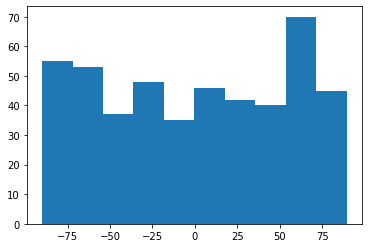

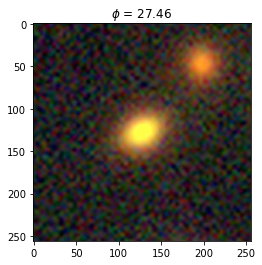

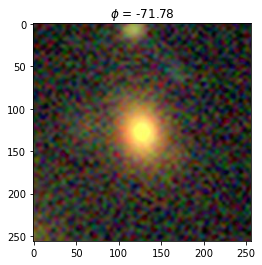

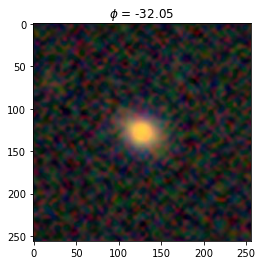

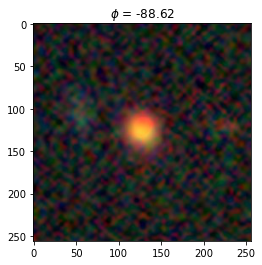

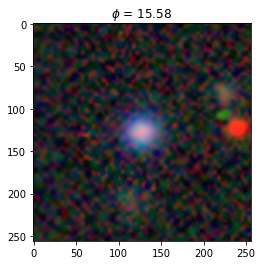

In [12]:
ii = (E_all > 0.1) & (E_all < 0.6)
print(sum(ii))
i = 0

RAAA = RA_all[ii]
DEEE = DEC_all[ii]
PHII = PHI_all[ii]

pl.hist(PHI_all[ii])
pl.show()

ii_sort = np.random.choice(len(RAAA), len(RAAA), replace=False)

for ra__, dec__, phi__ in zip(RAAA, DEEE, PHII):
    if i < 5:
        url_DES = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra__}&dec={dec__}&layer=ls-dr9&zoom=16'
        IMAGE_DES = load_image(url_DES)
        pl.imshow(IMAGE_DES)
        pl.title(f'$\phi$ = {phi__:.2f}')
        pl.show()
        i += 1
    else:
        break